In [3]:
import numpy as np
import time
from pyscf import scf
from pyscf.pbc import df as pdf
from pyscf.pbc import scf as pbchf
from pyscf.pbc import gto as pbcgto
from pyscf.pbc import cc as pbccc
from pyscf.pbc import tools
import matplotlib.pyplot as plt
import pandas as pd

def make_cell(dist,n_per_frag=1,sep=17.479,basis="sto3g"):
    atms = [
        ["C", (-0.5892731037811102, 0.3262391909203111, 0)],
        ["H", (-0.5866101957855856, 1.4126530286778238, 0)],
        ["C", (0.5916281105038108, -0.3261693897255898, 0)],
        ["H", (0.5889652025082863, -1.4125832274831025, 0)],
    ]
    els0 = [atm[0] for atm in atms]
    coords0 = np.array([atm[1] for atm in atms])
    els = els0.copy()
    coords = coords0.copy()

    for i in range(1,n_per_frag):
        coords2 = coords0 + np.vstack([np.array((dist*i,0,0))]*coords0.shape[0])
        coords = np.vstack([coords,coords2])
        els = els + els0

    atms = []
    for i,coord in enumerate(coords):
        atms += [[els[i],tuple(coord)]]
    cell = pbcgto.Cell()
    cell.build(a = [[dist*n_per_frag,0,0],[0,sep,0],[0,0,sep]],
               atom = atms,
               verbose = 0,
               basis=basis)
    return cell

def make_kpts(N,cell,kdover2pi=False):
    from pyscf.lib import param
    angstrom_to_bohr = 1/param.BOHR
    d = cell.a[0][0]
    if cell.unit not in ["bohr","B"]:
        d *= angstrom_to_bohr
    ks = np.arange(N)/N
    b = 2*np.pi/d
    kpts = np.zeros((N,3))
    kpts[:,0] = ks*b
    #Returns k, to get to kd/2pi multiply by d/2pi
    if kdover2pi:
        kpts *= d/(2*np.pi)
    return kpts

def make_and_run_mf(dist,nkpts,fnal="HF",n_per_frag=1,basis="sto3g"):
    cell = make_cell(dist,n_per_frag=n_per_frag,basis=basis)
    if fnal == "HF":
        mf = pbchf.KRHF(cell).density_fit()
    else:
        mf = pbchf.KRKS(cell,xc=fnal).density_fit()
    kpts2 = cell.make_kpts([nkpts,1,1])
    kpts = make_kpts(nkpts,cell)
    assert(np.allclose(kpts,kpts2))
    mf.kpts = kpts
    mf.kernel()
    
    energies, mos = mf.get_bands(kpts)
    energies = np.vstack(energies)
    kptsnorm = make_kpts(nkpts,cell,True)[:,0]
    kptsnorm = np.hstack([kptsnorm,np.array(1)]) #append gamma at end
    df = pd.DataFrame()
    for i in range(energies.shape[1]):
        e_band = energies[:,i]
        e_band = np.hstack([e_band,np.array(e_band[0])])
        for k,e in zip(kptsnorm,e_band):
            df.loc[k,i] = e
        df.loc["nocc",i] = mf.mo_occ[0][i]
    return df

class PeriodicData: #Periodic
    def __init__(self,df):
        # self.df = pd.read_csv(csv_fn,index_col=0)
        self.df = df
        self.mo_occ = self.df.loc["nocc"]
        self.df = self.df.drop("nocc")
        self.hartree_to_ev = 27.2114

    def get_homo(self):
        df = self.df.copy()
        homo_idx = np.where(self.mo_occ == 2)[0][-1]
        k = np.array(self.df.index).astype(float)
        energies = self.df.iloc[:,homo_idx].values
        energies *= self.hartree_to_ev
        return energies,k

    def get_lumo(self):
        df = self.df.copy()
        lumo_idx = np.where(self.mo_occ == 0)[0][0]
        k = np.array(self.df.index).astype(float)
        energies = self.df.iloc[:,lumo_idx].values
        energies *= self.hartree_to_ev
        return energies,k

DIST = 2.47
NKPTS = 16
FNAL = "HSE06"
N_PER_FRAG = 2
RESULTS = make_and_run_mf(DIST, NKPTS, FNAL, N_PER_FRAG, basis="3-21g")
RESULTS.to_csv(f"logs/periodic_{FNAL}_frag{N_PER_FRAG*2}C_24_k16.csv")

,IP,EA,GAP
HSE06,4.08,2.65,1.42


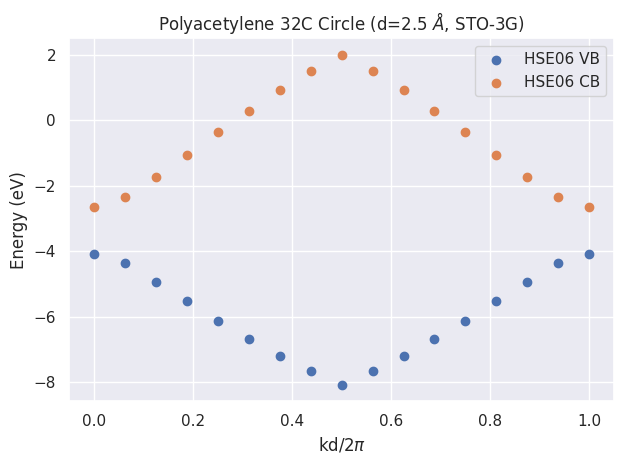

In [4]:
import seaborn as sns
sns.set()
per = PeriodicData(RESULTS)
df = pd.DataFrame()
e,k = per.get_homo()
df.loc[FNAL,"IP"] = -e.max()
plt.scatter(k,e,label=f"{FNAL} VB")
e,k = per.get_lumo()
df.loc[FNAL,"EA"] = -e.min()
df["GAP"] = (-df["EA"]) - (-df["IP"])
plt.scatter(k,e,label=f"{FNAL} CB")
plt.legend()
plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.title("Polyacetylene 32C Circle (d=2.5 $\AA$, STO-3G)")
plt.tight_layout()
plt.savefig(f"../figures/pacircle_periodic_bands_{FNAL}.png")
np.round(df,2)

## Molecular Calculations

In [21]:
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from systems.pacircle import PACircle

NCELLS = 16
N_PER_FRAG = 1
DIST = 2.47
geom = PACircle(DIST,NCELLS,N_PER_FRAG,fn="logs/pacircle.log")

mol = geom.get_mol()
mol.basis = "3-21g"
mol.build()
# mf = scf.RHF(mol)
mf = scf.RKS(mol)
mf.kernel()

homo_idx = np.where(mf.mo_occ == 2)[0][-1]
lumo_idx = np.where(mf.mo_occ == 0)[0][0]
homo_ene = mf.mo_energy[homo_idx]
lumo_ene = mf.mo_energy[lumo_idx]
gap = lumo_ene - homo_ene
gap *= 27.2114
gap

overwrite output file: logs/pacircle.log


1.0857534194312022

In [23]:
-homo_ene*27.2114

4.334545373942199

In [14]:
mol.nao    

192

In [7]:
hhf.mo_occ

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])